## Introduction

Beta banks, have noted that they are losing customers slowly. They came to the conclusion that it is less costly to maintain existing customers than it is to attract new ones. 

As a result of this I have been tasked to predict whether a customer will leave the bank soon based on historical data.

I have been tasked to use 
- **F-1 score** as the primary target metric. (F-1 => 0.59)
- **ROC_AUC score** as the secondary metric. 

### Libraries

In [1]:
import pandas as pd
import numpy as np

#charting
import matplotlib.pyplot as plt

#modeling and feature prep.
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix
from sklearn.utils import resample, shuffle

## Data Preperation

In [2]:
data = pd.read_csv('/Users/ericross/desktop/DataSets/Churn-beta_bank.csv')

In [3]:
data.sample(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
8634,8635,15656141,Ts'ao,741,France,Male,39,NaN,0.00,1,0,1,40207.06,0
6002,6003,15783026,H?,701,France,Female,41,2.0,0.00,1,1,0,47856.78,0
824,825,15603830,Palmer,600,Spain,Male,36,4.0,0.00,2,1,0,143635.36,0
3058,3059,15744279,Patterson,680,Spain,Female,58,8.0,0.00,2,1,1,65708.50,0
8258,8259,15699753,Zakharov,590,France,Male,41,1.0,89086.31,1,1,0,24499.97,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### Preprocessing

In [6]:
# Ease of life fix, Changing the column names to lowercase. 
data.columns = data.columns.str.lower()

##### duplicates 

In [7]:
data.duplicated().sum()

0

##### Missing Data analysis

In [8]:
ten_total = data.shape[0]

ten_missing_total =  data.tenure.isna().sum()

ten_mssing = ten_total /  ten_missing_total

print('Total Values:', ten_total)
print('Total Missing Values:', ten_missing_total)
print('Share of missing values:', ten_mssing,'%')

Total Values: 10000
Total Missing Values: 909
Share of missing values: 11.001100110011 %


In [9]:
missing_data = data.loc[(data['tenure'].isna())|(data['tenure'] == 0)].copy()
missing_data.fillna("X", inplace=True)

missing_data.sample(5)

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
8174,8175,15623525,Copeland,564,Spain,Male,31,0.0,125175.58,1,1,1,72757.33,0
9624,9625,15668309,Maslow,350,France,Female,40,0.0,111098.85,1,1,1,172321.21,1
111,112,15665790,Rowntree,538,Germany,Male,39,X,108055.10,2,1,0,27231.26,0
6006,6007,15636395,King,529,France,Female,31,X,0.00,2,1,0,26817.23,0
2691,2692,15629150,Lucchese,721,France,Female,37,X,0.00,2,1,0,70810.80,0


In [10]:
missing_data[['exited', 'tenure']].value_counts()

exited  tenure
0       X         726
        0.0       292
1       X         183
        0.0        90
dtype: int64

I do not see any clear causes for the lack of a tenure present. I also tested to see if the missing values could correspond with a customer being new and therefore having 0 tenure. It also appears that a majority of the missing rows belong to current customers which could lead to inaccurate predictions of churn if filled with the mean values for the column this.  Subsequently, these rows will be removed for now, however this could be rectified by simply adding a column with the start and end dates of customer for this data.  


In [11]:
clean_data = data.dropna()


clean_data.isna().sum()

rownumber          0
customerid         0
surname            0
creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

In [12]:
clean_data.shape

(9091, 14)

##### Removing uninformative columns 

In [13]:
del clean_data['rownumber']
del clean_data['surname']

**Preprocessing Conclusion**

Column Names
- Column names were converted to the lower case letters for ease of use. 

Missing Data
- there were 909 missing values out of 10,000 (~11%), which have been removed form the data. 

Uninformative columns removed. 
- 'rownumber' and 'surname' columns were dropped from the data. 


### Encoding Data

In [14]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       9091 non-null   int64  
 1   creditscore      9091 non-null   int64  
 2   geography        9091 non-null   object 
 3   gender           9091 non-null   object 
 4   age              9091 non-null   int64  
 5   tenure           9091 non-null   float64
 6   balance          9091 non-null   float64
 7   numofproducts    9091 non-null   int64  
 8   hascrcard        9091 non-null   int64  
 9   isactivemember   9091 non-null   int64  
 10  estimatedsalary  9091 non-null   float64
 11  exited           9091 non-null   int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 923.3+ KB


In [15]:
clean_data.head()

,customerid,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,15634602,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [16]:
data_ohe = pd.get_dummies(clean_data, drop_first=True)
    
data_ohe.head()    

,customerid,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,15634602,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,15647311,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,15619304,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,15701354,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,15737888,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


## Target Imbalance

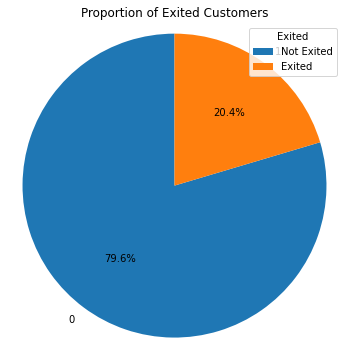

In [17]:
# Assuming data_ohe is your DataFrame and 'exited' is one of its columns
exited_table = data_ohe['exited'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(exited_table, labels=exited_table.index, autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Exited Customers')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(title='Exited', loc='upper right', labels=['Not Exited', 'Exited'])
plt.show()

## splitting data

###### Test Set

In [18]:
train, test = train_test_split(data_ohe, test_size=0.25, random_state=22244, stratify=data_ohe['exited'])

In [19]:
target_test = test['exited']
features_test = test.drop(['exited','customerid'], axis=1)

In [20]:
# checking stratified balance 
def print_imbalance(target):
    ones = target.sum()
    zeros = target.count() - ones
    percent = ones / target.count() * 100

    print(f'Exited: {ones} \nNon-Exited: {zeros}')
    print(f'Percent Exited: {percent:.1f}%')

In [21]:
print_imbalance(target_test)

Exited: 464 
Non-Exited: 1809
Percent Exited: 20.4%


###### Validation Set

In [22]:
train, valid = train_test_split(train, test_size=0.20, random_state=22244, stratify=train['exited'])

In [23]:
target_train = train['exited']
features_train = train.drop(['exited','customerid'], axis=1)

target_valid = valid['exited']
features_valid = valid.drop(['exited','customerid'], axis=1)

In [24]:
print_imbalance(target_valid)

Exited: 278 
Non-Exited: 1086
Percent Exited: 20.4%


## Modeling with class imbalances

In [25]:
def model_randforest(features_train, target_train, features_valid, target_valid):
    model = RandomForestClassifier(random_state=22244)
    model.fit(features_train, target_train)
    
    predicted = model.predict(features_valid)
    
    proba = model.predict_proba(features_valid)
    
    proba_one = proba[:, 1]

    f1 = f1_score(target_valid, predicted)
    roc_auc = roc_auc_score(target_valid, proba_one)
    
    return f1, roc_auc, predicted, proba_one

In [26]:
def model_eval(target_valid, predicted, probabilities_one, suptitle=None, color='blue', matrix_color='Blues'):
    """
    Evaluate a classification model by plotting precision-recall curve, ROC curve,
    and confusion matrix.

    Parameters:
        target_valid (array-like): True labels of the validation set.
        predicted (array-like): Predicted labels of the validation set.
        probabilities_one (array-like): Probabilities of the positive class for the validation set.
        suptitle (str, optional): Title for the entire figure. Default is None.
        color (str, optional): Color of the line plots. Default is 'blue'.
        matrix_color (str, optional): Color map for the confusion matrix.
            Available options include 'Blues', 'Greens', 'Reds', 'Oranges', 'Purples', 'Greys', and more.
            Default is 'Blues'.

    Returns:
        None
    """

    # Compute precision, recall, and thresholds for the Precision-Recall curve
    precision, recall, thresholds_pr = precision_recall_curve(target_valid, probabilities_one)

    # Compute false positive rate, true positive rate, and thresholds for the ROC curve
    fpr, tpr, thresholds_roc = roc_curve(target_valid, probabilities_one)

    # Compute confusion matrix
    base_cm = confusion_matrix(target_valid, predicted)

    # Compute ROC AUC score and F1 score
    roc_auc = roc_auc_score(target_valid, probabilities_one)
    f1 = f1_score(target_valid, predicted)

    # Create a figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Adjust the aspect ratio of each subplot to make them square
    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')
    axes[2].set_aspect('equal')

    # Plot the Precision-Recall curve
    axes[0].plot(recall, precision, color=color)
    axes[0].set_title(f'Precision-Recall (F1) Curve\nF1 Score: {f1:.4f}', fontsize=12)
    axes[0].set_xlabel('Recall')
    axes[0].set_ylabel('Precision')

    # Plot the ROC curve
    axes[1].plot(fpr, tpr, color=color)
    axes[1].set_title(f'ROC Curve\nROC AUC Score: {roc_auc:.4f}', fontsize=12)
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')

    # Plot the Confusion Matrix
    im = axes[2].imshow(base_cm, cmap=matrix_color)
    axes[2].set_title('Confusion Matrix', fontsize=12)
    axes[2].set_xlabel('Predicted label')
    axes[2].set_ylabel('True label')
    tick_marks = np.arange(2)
    axes[2].set_xticks(tick_marks)
    axes[2].set_yticks(tick_marks)

    # Add labels to each cell of the Confusion Matrix
    thresh = base_cm.max() / 2.
    for i, j in np.ndindex(base_cm.shape):
        axes[2].text(j, i, format(base_cm[i, j], 'd'),
                     horizontalalignment="center",
                     fontsize=14,
                     color="white" if base_cm[i, j] > thresh else "black")

    # Add a color bar on the right side of the confusion matrix
    cbar = fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

    # Add a title for the entire figure
    fig.suptitle(suptitle, fontsize=20, y=1)
    fig.set_facecolor('white')

In [27]:
base_f1, base_roc_auc, base_predicted, base_proba_one = model_randforest(features_train, target_train, features_valid, target_valid)

print(f'F1-score: {base_f1:.2f}\n ROC_AUC: {base_roc_auc:.2f}')

F1-score: 0.57
 ROC_AUC: 0.83


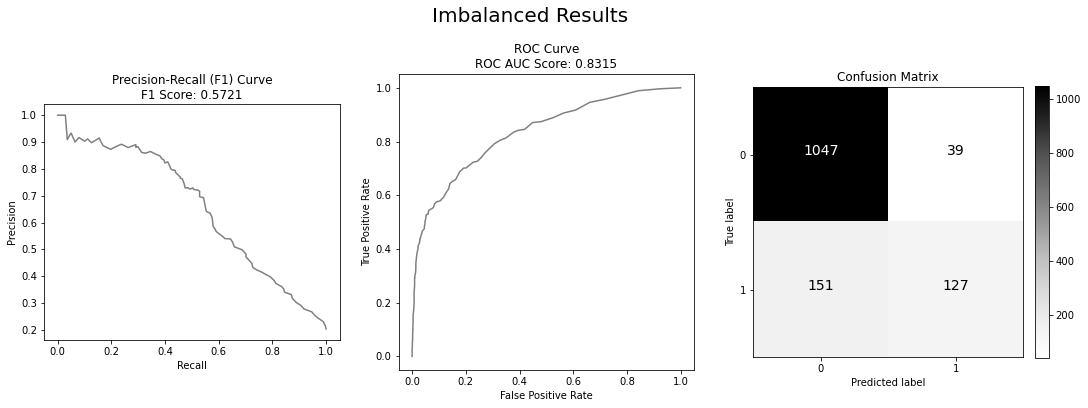

In [28]:
model_eval(target_valid, base_predicted, base_proba_one, suptitle="Imbalanced Results", color='Grey', matrix_color='Greys')

###### Conclusion

* True Negative = 1047 - Correct, 0
* False negative = 39 - Incorrct, 0

* False Positive = 151  - Incorrect, 1
* True Positive =  127 - Correct, 1

**Observations:**
             
- F1 Score: :0.5721  
- ROC-AUC:  :0.8315   
    
**Conclusion** 
The Class Imbalance seems to create a model that predicts only the negative class well. This issue must be fixed before tuning and testing the model. 

## Methods for Handling Class Imbalance

Method 1-1: Up Sampling
- In this method, the minority class instances are replicated or synthesized to increase their representation in the dataset, addressing the class imbalance issue and improving the model's performance on the minority class.

Method 1-2: Over Sampling
- This approach involves replicating or synthesizing instances of the minority class to create a more balanced class distribution, allowing the model to learn from the minority class more effectively and improve its performance on the minority class.

Method 2-1: Down Sampling
- In this method, instances of the majority class are reduced to match the number of instances in the minority class, creating a balanced class distribution and potentially improving the model's performance on both classes.

Method 2-2: Under Sampling
- Similar to down sampling, this approach reduces instances of the majority class to address class imbalance. By decreasing the dominance of the majority class, the model can focus more on the minority class and potentially enhance its performance on both classes.

Method 3: Class Weight Parameter 
- This method assigns different weights to the classes during the model training process, giving higher importance to the minority class. By adjusting the class weights, the model can focus more on correctly predicting instances of the minority class and improve its performance on the minority class while maintaining performance on the majority class.

###### Method 1-1: up sampling 

In [29]:
def upsample(features, target):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    # Calculate the repeat value based on the ratio of minority to majority class
    repeat = len(target_zeros) // len(target_ones)

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=22244
    )

    return features_upsampled, target_upsampled


In [30]:
upsampled_features_train, upsampled_target_train = upsample(features_train, target_train)

print_imbalance(upsampled_target_train)

Exited: 3336 
Non-Exited: 4342
Percent Exited: 43.4%


###### Method 1-2: Over Sampling

In [31]:
def oversample(features, target, minority_class_label=1, majority_class_label=0, random_state=22244):
    # Separate minority and majority class samples
    minority_features = features[target == minority_class_label]
    minority_target = target[target == minority_class_label]
    majority_features = features[target == majority_class_label]
    majority_target = target[target == majority_class_label]

    # Calculate the oversampling ratio
    oversampling_ratio = len(majority_features) / len(minority_features)

    # Oversample the minority class
    minority_features_oversampled = resample(minority_features,
                                             replace=True,
                                             n_samples=int(oversampling_ratio * len(minority_features)),
                                             random_state=random_state)
    minority_target_oversampled = resample(minority_target,
                                           replace=True,
                                           n_samples=int(oversampling_ratio * len(minority_target)),
                                           random_state=random_state)

    # Combine oversampled minority class with majority class
    features_oversampled = pd.concat([minority_features_oversampled, majority_features])
    target_oversampled = pd.concat([minority_target_oversampled, majority_target])

    return features_oversampled, target_oversampled

In [32]:
oversampled_features_train, oversampled_target_train = oversample(features_train, target_train)

print_imbalance(oversampled_target_train)

Exited: 4342 
Non-Exited: 4342
Percent Exited: 50.0%


###### Method 2-1: down sampling

In [33]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=22244)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=22244)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=22244
    )

    return features_downsampled, target_downsampled


In [34]:
downsampled_features_train, downsampled_target_train = downsample(features_train, target_train, 0.25595676737902234)

print_imbalance(downsampled_target_train)

Exited: 1112 
Non-Exited: 1111
Percent Exited: 50.0%


###### Method 2-2: under sampling 

In [35]:
def random_undersampling(features, target):
    # Separate majority and minority classes
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    # Determine the size of the majority class
    majority_class_size = len(features_zeros)

    # Undersample the majority class
    features_zeros_undersampled = resample(features_zeros, replace=False, n_samples=len(features_ones), random_state=22244)
    target_zeros_undersampled = resample(target_zeros, replace=False, n_samples=len(target_ones), random_state=22244)

    # Combine the undersampled majority class with the minority class
    features_undersampled = pd.concat([features_zeros_undersampled, features_ones])
    target_undersampled = pd.concat([target_zeros_undersampled, target_ones])

    # Shuffle the undersampled data
    combined_data = pd.concat([features_undersampled, target_undersampled], axis=1)
    combined_data = combined_data.sample(frac=1, random_state=22244).reset_index(drop=True)

    # Split the features and target variables
    features_undersampled = combined_data.iloc[:, :-1]
    target_undersampled = combined_data.iloc[:, -1]

    return features_undersampled, target_undersampled

In [36]:
undersampled_features_train, undersampled_target_train = random_undersampling(features_train, target_train)

print_imbalance(undersampled_target_train)

Exited: 1112 
Non-Exited: 1112
Percent Exited: 50.0%


## Modeling Class Imbalance Adjustments  

### Method 1-1 Up Sampling 

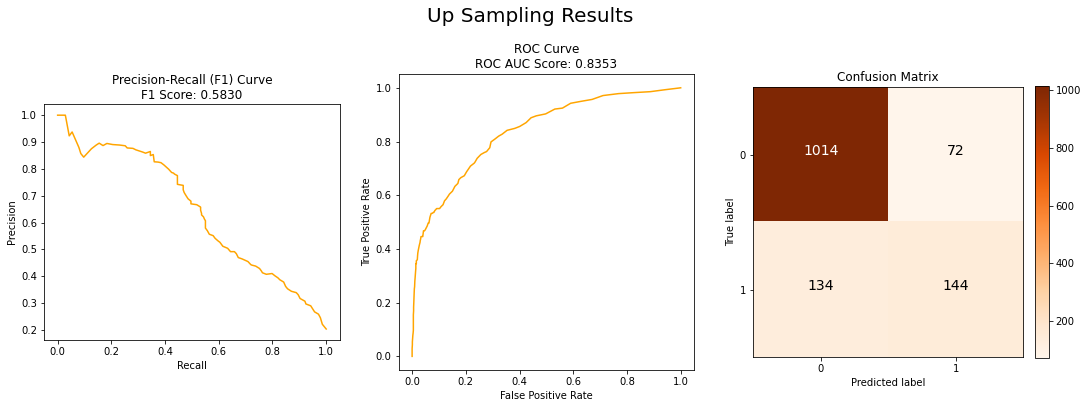

In [37]:
up_f1, up_roc_auc, up_predicted, up_proba_one = model_randforest(upsampled_features_train, upsampled_target_train, features_valid, target_valid)
model_eval(target_valid, up_predicted, up_proba_one, suptitle="Up Sampling Results", color='orange', matrix_color='Oranges')

### Method 1-2 Over Sampling 

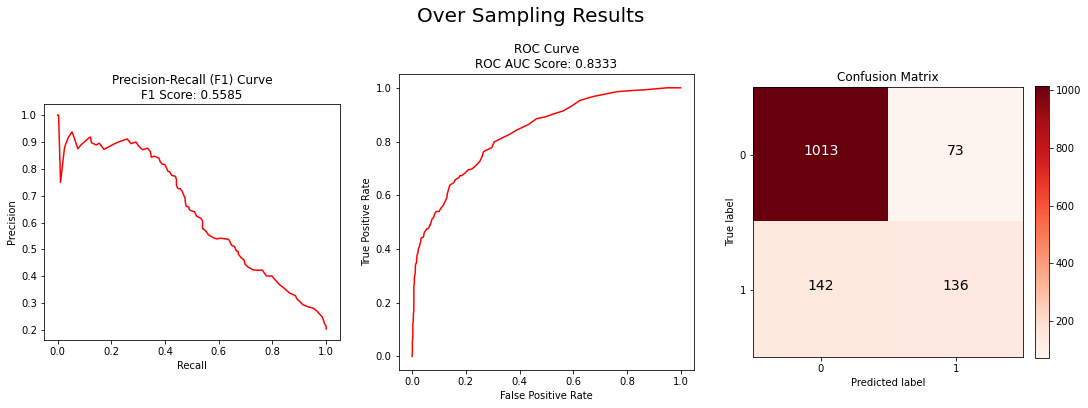

In [38]:
over_f1, over_roc_auc, over_predicted, over_proba_one = model_randforest(oversampled_features_train, oversampled_target_train, features_valid, target_valid)

model_eval(target_valid, over_predicted, over_proba_one, suptitle="Over Sampling Results", color='Red', matrix_color='Reds')

### Method 2-1 : Downsampling

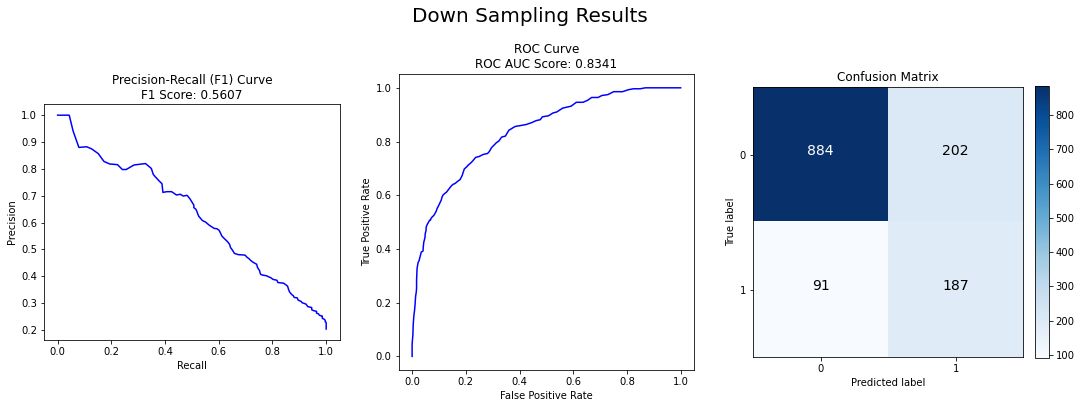

In [39]:
down_f1, down_roc_auc, down_predicted, down_proba_one = model_randforest(downsampled_features_train, downsampled_target_train, features_valid, target_valid)

model_eval(target_valid, down_predicted, down_proba_one, suptitle="Down Sampling Results")

### Method 2-2 Under Sampling

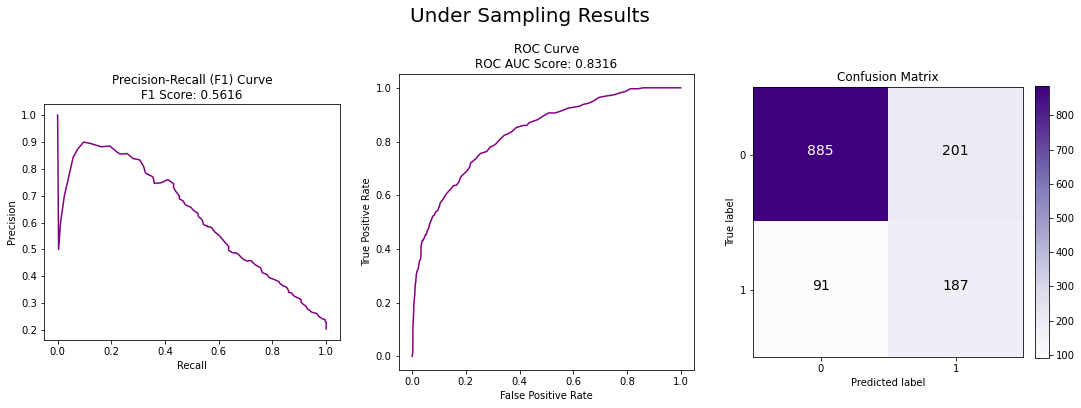

In [40]:
under_f1, under_roc_auc, under_predicted, under_proba_one = model_randforest(undersampled_features_train, undersampled_target_train, features_valid, target_valid)

model_eval(target_valid, under_predicted, under_proba_one, suptitle='Under Sampling Results', color='Purple', matrix_color='Purples')

### method 3 : Class_weight = 'balanced'

In [41]:
model = RandomForestClassifier(class_weight='balanced', random_state=22244)
model.fit(features_train, target_train)
balanced_predicted = model.predict(features_valid)

balanced_proba = model.predict_proba(features_valid)
balanced_proba_one = balanced_proba[:, 1]

balanced_f1 = f1_score(target_valid, balanced_predicted)

balanced_roc_auc = roc_auc_score(target_valid, balanced_proba_one)

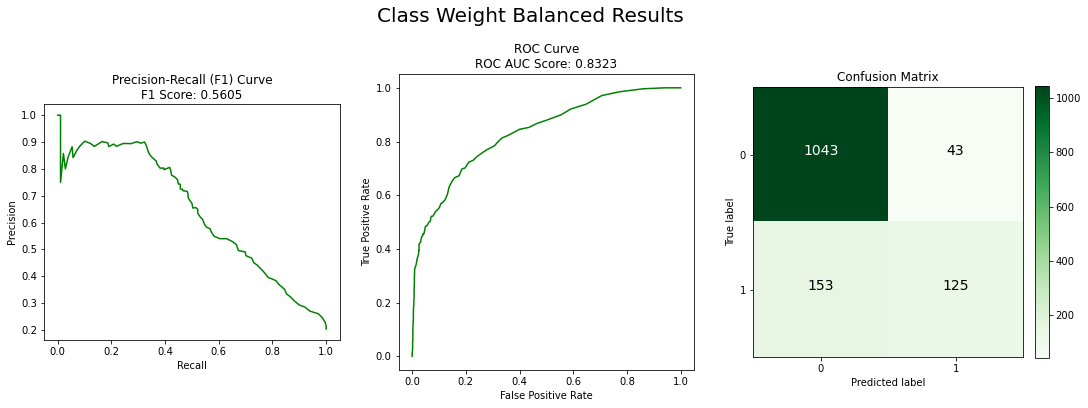

In [42]:
model_eval(target_valid, balanced_predicted, balanced_proba_one, suptitle='Class Weight Balanced Results', color='Green', matrix_color='Greens')

### Conclusion -  Fixing Class Imbalance

**Base Features**

F1  = 0.5721

ROC_AUC = 0.8402


**Up Sampled**

F1 = 0.5830

ROC_AUC = 0.8353

**Over Sampled**

F1 - 0.5585

ROC_AUC - 0.8333

**Down Sampled**

F1 - 0.5607
ROC_AUC - 0.8341


**Under Sampled**

F1 - 0.5616

ROC_AUC - 0.8316


**Balanced Class Weights**

F1 - 0.5605

ROC_AUC - 0.8323


## Model Adjustments 

### Logistic Regression Model - Base Line

###### Up Sampled data

In [44]:
model =  LogisticRegression(random_state=22244, solver="liblinear")
model.fit(upsampled_features_train, upsampled_target_train)
predicted_valid = model.predict(features_valid)
f1_score(target_valid, predicted_valid)

0.41379310344827586

###### Down Sampled Data

In [43]:
model =  LogisticRegression(random_state=22244, solver="liblinear")
model.fit(downsampled_features_train, downsampled_target_train)
predicted_valid = model.predict(features_valid)
f1_score(target_valid, predicted_valid)

0.41860465116279066

## Random Forest Model - Adjustments

###### Upsampled data

In [45]:
best_score = 0
best_params = {}

for est in range(3, 80):
    for depth in range(2, 15):
        model = RandomForestClassifier(random_state=22244, n_estimators=est, max_depth=depth)
        model.fit(upsampled_features_train, upsampled_target_train)
        predicted_valid = model.predict(features_valid)
        score = f1_score(target_valid, predicted_valid)
        
        if score > best_score:
            best_score = score
            best_params['max_estimators'] = est
            best_params['max_depth'] = depth
    
print("Best F1 Score:", best_score)
print("Best Parameters:", best_params)

Best F1 Score: 0.6098003629764066
Best Parameters: {'max_estimators': 31, 'max_depth': 9}


###### Under Sampled

In [46]:
best_score = 0
best_params = {}

for est in range(3, 80):
    for depth in range(2, 15):
        model = RandomForestClassifier(random_state=22244, n_estimators=est, max_depth=depth)
        model.fit(undersampled_features_train, undersampled_target_train)
        predicted_valid = model.predict(features_valid)
        score = f1_score(target_valid, predicted_valid)
        
        if score > best_score:
            best_score = score
            best_params['max_estimators'] = est
            best_params['max_depth'] = depth
    
print("Best F1 Score:", best_score)
print("Best Parameters:", best_params)

Best F1 Score: 0.5924812030075188
Best Parameters: {'max_estimators': 73, 'max_depth': 8}


######  Class_Weight = 'balanced' data

In [47]:
best_score = 0
best_params = {}

for est in range(3, 80):
    for depth in range(2, 15):
        model = RandomForestClassifier(class_weight='balanced',random_state=22244, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        score = f1_score(target_valid, predicted_valid)
        
        if score > best_score:
            best_score = score
            best_params['max_estimators'] = est
            best_params['max_depth'] = depth
    
print("Best F1 Score:", best_score)
print("Best Parameters:", best_params)

Best F1 Score: 0.6040268456375839
Best Parameters: {'max_estimators': 18, 'max_depth': 8}


### Conclusion - Model Training Evaluation

**Up Sampled**

- F1 Score: 0.6098003629764066
- Best Parameters: {'max_estimators': 31, 'max_depth': 9}

**Under Sampled**

- F1 Score: 0.5924812030075188
- Best Parameters: {'max_estimators': 73, 'max_depth': 8}

**class_weight='balanced**

- F1 Score: 0.6040268456375839
- Best Parameters: {'max_estimators': 18, 'max_depth': 8}


Conclusion:

Based on the results, the "Up Sampled" model achieved the highest F1 score of 0.6098, demonstrating its effectiveness in addressing the class imbalance by oversampling the minority class. The model's chosen parameters of 'max_estimators': 31 and 'max_depth': 9 strike a good balance between complexity and generalization. The "class_weight='balanced'" model is also a strong contender, with an F1 score of 0.6040, effectively handling class imbalance through built-in class weighting. Its parameters, 'max_estimators': 18 and 'max_depth': 8, contribute to its competitive performance. Both models exhibit potential for accurate churn prediction, but I will use Up Sampling model to for testing. 


## Final Model Testing

In [48]:
model = RandomForestClassifier(random_state=22244, n_estimators =31, max_depth= 9)
model.fit(upsampled_features_train, upsampled_target_train)

final_predicted = model.predict(features_test)

final_proba = model.predict_proba(features_test)
final_proba_one = final_proba[:, 1]


final_f1_score = f1_score(target_test, final_predicted)

final_roc_auc = roc_auc_score(target_test, final_proba_one)

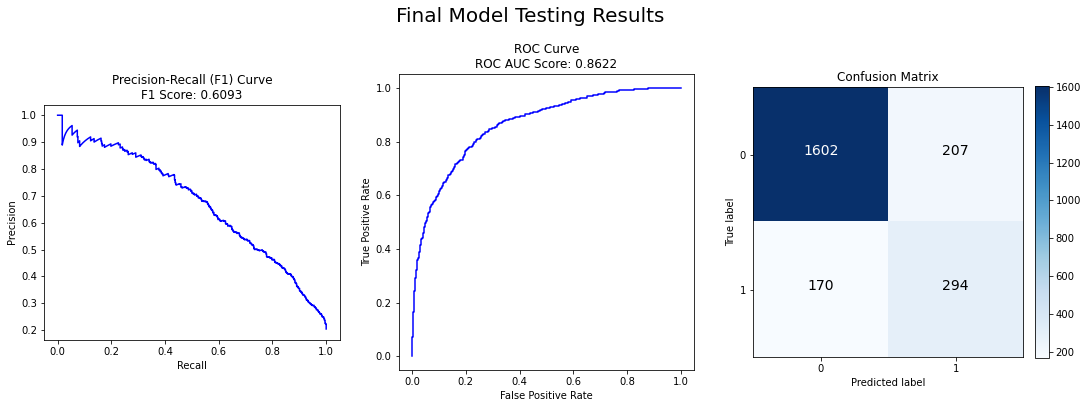

In [49]:
model_eval(target_test, final_predicted, final_proba_one, suptitle='Final Model Testing Results')

### Model Testing Conclusion

Method 1-1 Up Sampling 

- Preformed the best for this task, achieving the highest F1 for Training.  

Final Model Results

F1 - 0.6093
ROC_AUC - 0.8622

- [1602, 207]
- [ 170, 294]


**Final Conclusion:**

  Based on the final model results, the "Up Sampling" method performed the best for churn prediction, achieving the highest F1 score of 0.6093 during training. The model's performance on the validation set showcased an F1 score of 0.6059 and an ROC_AUC score of 0.8455, which met the company's performance standard. The model demonstrated a balanced trade-off between precision and recall, indicating its ability to accurately identify a substantial portion of potential churn customers. This outcome is significant for the company's churn prediction efforts, highlighting the effectiveness of the "Up Sampling" technique in capturing and addressing class imbalance to improve churn prediction accuracy.


**Final Notes for Further Improvement**

To further enhance the prediction quality of a model, two effective methods can be utilized: SMOTE (Synthetic Minority Over-sampling Technique) and Cluster Centroids.

SMOTE generates synthetic samples by interpolating feature vectors of minority class instances, thus increasing the diversity of the dataset. This technique helps to address class imbalance and can improve the model's ability to capture important patterns within the minority class.

Cluster Centroids, on the other hand, identifies clusters within the majority class and generates synthetic samples by replacing each cluster centroid with a randomly selected instance from the cluster. This approach helps in reducing the majority class instances and achieving a more balanced dataset.

By incorporating these techniques into the model training process, it is possible to further improve the model's ability to handle class imbalance and enhance its prediction quality.